In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# 2. Model selection

## 2.1. Preprocessing

We will apply the lessons learned during the data exploration to our dataset, before looking into potential regression algorithms for our specific problem.

In [3]:
diam_data = pd.read_csv('diamonds.csv', index_col = 0)
diam_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Our ultimate target is the price, which will be computed as $price/carat \times weight$. For our model, the target will however be the price/carat.

In [4]:
y = np.divide(diam_data['price'], diam_data['carat'])
y.head()

1    1417.391304
2    1552.380952
3    1421.739130
4    1151.724138
5    1080.645161
dtype: float64

In [5]:
X = diam_data.drop(columns=['price'])
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


We know a step is the log-transformation of our target variable.

In [6]:
target_transform = TransformedTargetRegressor(
    regressor=None, #To be set for each model
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

Another step includes binning the 'carat' column, before using it in the model.

Scikit-learn does not have a simple function to achieve this with given bin edges, so we will create one that can be used in a pipeline.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class CustomBinDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 bins,
                 right: 'bool' = True,
                 labels=None,
                 retbins: 'bool' = False,
                 precision: 'int' = 3,
                 include_lowest: 'bool' = False,
                 duplicates: 'str' = 'raise',
                 ordered: 'bool' = True):
        self.bins = bins
        self.right = right
        self.labels = labels
        self.retbins = retbins
        self.precision = precision
        self.include_lowest = include_lowest
        self.duplicates = duplicates
        self.ordered = ordered

    def fit(self, X, y=None):
        #Nothing to fit, given custom bins
        return self

    def transform(self, X, y=None):
        # if isinstance(X, pd.DataFrame), ("Only pandas dataframes can be used as inputs for this function")
        X_new = pd.DataFrame(X)
        for col in X_new.columns:
            X_new.loc[:, col] = pd.cut(x=X_new.loc[:, col].values, **self.__dict__)
        return X_new

We then initialize this custom class with the relevant parameters.

In [9]:
discretizer = CustomBinDiscretizer(
    labels=False, #No labels, using int ordinal instead directly
    bins=[0, .5, .75, 1, 1.5, 2, +np.inf]
)

Another step involves the imputation, through bayesian ridge regression, of the missing x values, if any.

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [11]:
#Imputation step
imputer = IterativeImputer(missing_values=0, random_state=50)

Depending on the algorithm used, we may also need additional steps:
- Encoding (ordinally, or one-hot) categorical variables
- Standard-scaling numerical values

In [12]:
#Define ordinal order for the encoded categorical variables
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

In [13]:
#Initialize encoders
oh_encoder = OneHotEncoder()
or_encoder = OrdinalEncoder(categories = [cut_order, clarity_order])

In [14]:
#Initialize scalers
scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [15]:
#Preprocessing steps for columns used in imputer
preprocess_imputer = ColumnTransformer([
    ('discretizer', discretizer, [0]), #Using lists of scalar as column position, as the name gets removed after the first step (imputer)
    ('scaler', scaler, [1])
])

#Combining the two
prep_imputer = Pipeline([
    ('imputer', imputer),
    ('preprocess_imputer', preprocess_imputer)
])

#Preprocessing steps for ordinal encoding
or_encoder_scaler = Pipeline([
        ('or_encoder', or_encoder),
        ('mm_scaler', mm_scaler)
])

#Overall preprocessing
preprocess = ColumnTransformer(
    [
        ('prep_imputer', prep_imputer, ['carat', 'x']),
        ('oh_encoder', oh_encoder, ['color']),
        ('or_encoder_scaler', or_encoder_scaler, ['cut', 'clarity']),
        ('scaler', scaler, ['depth', 'table'])
    ],
    remainder='drop'
)

## 2.2. Models

We can now start looking at potential predictive models based on our dataset.
We will use 80% of the data for training purposes, and the remaining 20% as a test set.
The models will be fit with 5-fold cross-validation on the direct training set, using the mean squared error as the main loss function, and a combination of factors on the 5 folds will be used for model selection.

In [16]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=50)

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

### 2.2.1. Stochastic Gradient Descent regressor with elasticnet penalty

Our first model will be an elasticnet model. Given the relatively high number of datapoints, we will use stochastic gradient descent to find the parameters.

In [18]:
#Define the model
sgdr_model = SGDRegressor(
    loss='squared_error',
    penalty='elasticnet',
    random_state=50
)

In [19]:
#Create a pipeline with preprocessing + model
sgdr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', sgdr_model)
])

In [20]:
sgdr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('scaler',
                                                                                                    StandardScaler(),
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('...
                                                  ['color']),
                                                 ('or_encoder_scaler',
                                                  Pipeline(steps=[('or_encoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']])),
                                                                  ('mm_scaler',
                                                        

In [21]:
#Include the log-transformation of the target into the model
sgdr_pipe_transform = TransformedTargetRegressor(
    regressor=sgdr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [22]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__alpha': np.logspace(-5,0,6),
    'regressor__model__l1_ratio': np.linspace(0.1,0.9,5)
}

In [23]:
#Define evaluation metrics
metrics = ['neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'r2']

We also include a 5-fold grid search to optimize the hyperparameters of our model.

In [24]:
#Include the model into the grid search
sgdr_pipe_transform = GridSearchCV(
    sgdr_pipe_transform,
    param_grid=grid,
    scoring=metrics,
    refit='neg_mean_squared_error',
    cv=5,
    n_jobs=10
)

In [25]:
sgdr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                              ['depth',
                                                                                                               'table'])])),
                                                                            ('model',
                                                                             SGDRegressor(penalty='elasticnet',
                                                                                          random_state=50))])),
             n_jobs=10,
             param_grid={'regressor__model__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'regressor__model__l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error', 'r2'])

### 2.2.2. Partial Least Squares regressor

The second model we will fit is a partial least squares regressor. This family of models apply a linear regression on a reduced-dimensional space.

In [26]:
#Define the model
plsr_model = PLSRegression(
    scale=False
)

In [27]:
#Create a pipeline with preprocessing + model
plsr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', plsr_model)
])

In [28]:
plsr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('scaler',
                                                                                                    StandardScaler(),
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('...ncoder', OneHotEncoder(),
                                                  ['color']),
                                                 ('or_encoder_scaler',
                                                  Pipeline(steps=[('or_encoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']])),
                                                                  ('mm_scaler',
                               

In [29]:
#Include the log-transformation of the target into the model
plsr_pipe_transform = TransformedTargetRegressor(
    regressor=plsr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [30]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__n_components': [2,4,6,8],
}

In [31]:
#Include the model into the grid search
plsr_pipe_transform = GridSearchCV(
    plsr_pipe_transform,
    param_grid=grid,
    scoring=metrics,
    refit='neg_mean_squared_error',
    cv=5,
    n_jobs=10
)

In [32]:
plsr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                                                                           'SI1',
                                                                                                                                                           'VS2',
                                                                                                                                                           'VS1',
                                                                                                                                                           'VVS2',
                                                                                                                                                           'VVS1',
                                                                                                                                                           'IF']])),
                                                                                                                              ('mm_scaler',
                                                                                                                               MinMaxScaler())]),
                                                                                                              ['cut',
                                                                                                               'clarity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['depth',
                                                                                                               'table'])])),
                                                                            ('model',
                                                                             PLSRegression(scale=False))])),
             n_jobs=10,
             param_grid={'regressor__model__n_components': [2, 4, 6, 8]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error', 'r2'])

### 2.2.3. KNN regressor

The third model we will fit will be based on the K-nearest-neighbors algorithm.

In [33]:
#Define the model
knnr_model = KNeighborsRegressor(
    n_jobs=10
)

In [34]:
#Create a pipeline with preprocessing + model
knnr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', knnr_model)
])

In [35]:
knnr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('scaler',
                                                                                                    StandardScaler(),
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('...er', OneHotEncoder(),
                                                  ['color']),
                                                 ('or_encoder_scaler',
                                                  Pipeline(steps=[('or_encoder',
                                                                   OrdinalEncoder(categories=[['Fair',
                                                                                               'Good',
                                                                                               'Very '
                                                                                               'Good',
                                                                                               'Premium',
                                                                                               'Ideal'],
                                                                                              ['I1',
                                                                                               'SI2',
                                                                                               'SI1',
                                                                                               'VS2',
                                                                                               'VS1',
                                                                                               'VVS2',
                                                                                               'VVS1',
                                                                                               'IF']])),
                                                                  ('mm_scaler',
                                   

In [36]:
#Include the log-transformation of the target into the model
knnr_pipe_transform = TransformedTargetRegressor(
    regressor=knnr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [37]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__weights': ['uniform', 'distance'],
}

In [38]:
#Include the model into the grid search
knnr_pipe_transform = GridSearchCV(
    knnr_pipe_transform,
    param_grid=grid,
    scoring=metrics,
    refit='neg_mean_squared_error',
    cv=5
)

In [39]:
knnr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                                                                           'VS2',
                                                                                                                                                           'VS1',
                                                                                                                                                           'VVS2',
                                                                                                                                                           'VVS1',
                                                                                                                                                           'IF']])),
                                                                                                                              ('mm_scaler',
                                                                                                                               MinMaxScaler())]),
                                                                                                              ['cut',
                                                                                                               'clarity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['depth',
                                                                                                               'table'])])),
                                                                            ('model',
                                                                             KNeighborsRegressor(n_jobs=10))])),
             param_grid={'regressor__model__weights': ['uniform', 'distance']},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error', 'r2'])

### 2.2.4. Light GBM regressor

Finally, we will look into a boosting regression model, using the fast Light GBM algorithm.

In [40]:
#Define the model
lgbr_model = LGBMRegressor(
    boosting_type='gbdt',
    n_jobs=10,
    random_state=50
)

Considering the tree-based gradient boosting model used here, we will adapt the preprocessing steps, by removing the transformations that should not have a material impact, and that may increase processing time. Hence, we will only consider the imputation step, removing the encoding steps (no need for specific ordering or one-hot encoding), and the scaling step (tree invariant through standard scaling).

In [41]:
#Adapt preprocessing steps
tree_preprocess_imputer = ColumnTransformer([
    ('discretizer', discretizer, [0]), #Using lists of scalar as column position, as the name gets removed after the first step (imputer)
    ('passthrough', 'passthrough', [1])
])

tree_prep_imputer = Pipeline([
    ('imputer', imputer),
    ('preprocess_imputer', tree_preprocess_imputer)
])

tree_or_encoder = OrdinalEncoder()

tree_preprocess = ColumnTransformer(
    [
        ('prep_imputer', tree_prep_imputer, ['carat', 'x']),
        ('or_encoder', tree_or_encoder, ['color', 'cut', 'clarity']),
        ('passthrough', 'passthrough', ['depth', 'table'])
    ],
    remainder='drop'
)

In [42]:
#Create a pipeline with preprocessing + model
lgbr_pipe = Pipeline([
    ('preprocess', tree_preprocess),
    ('model', lgbr_model)
])

In [43]:
lgbr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('passthrough',
                                                                                                    'passthrough',
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('or_encoder',
                                                  OrdinalEncoder(),
                                                  ['color', 'cut', 'clarity']),
                                                 ('passthrough', 'passthrough',
                                                  ['depth', 'table'])])),
                ('model', LGBMRegressor(n_jobs=10, random_state=50))])

In [44]:
#Include the log-transformation of the target into the model
lgbr_pipe_transform = TransformedTargetRegressor(
    regressor=lgbr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [45]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__max_depth': [10, 50, 100],
    'regressor__model__reg_alpha': np.logspace(-2,0,3),
    'regressor__model__reg_lambda': np.logspace(-2,0,3)
}

In [46]:
#Include the model into the grid search
lgbr_pipe_transform = GridSearchCV(
    lgbr_pipe_transform,
    param_grid=grid,
    scoring=metrics,
    refit='neg_mean_squared_error',
    cv=5
)

In [47]:
lgbr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                              'passthrough',
                                                                                                              ['depth',
                                                                                                               'table'])])),
                                                                            ('model',
                                                                             LGBMRegressor(n_jobs=10,
                                                                                           random_state=50))])),
             param_grid={'regressor__model__max_depth': [10, 50, 100],
                         'regressor__model__reg_alpha': array([0.01, 0.1 , 1.  ]),
                         'regressor__model__reg_lambda': array([0.01, 0.1 , 1.  ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error', 'r2'])

## 2.3. Model comparison

We can now compare the 4 models, by looking at the average metrics obtained across the 5 training folds used during the grid search, with the hyperparameters that yielded the best mean squared error.

In [82]:
def compute_model_metrics(model_list, model_name_list):
    
    """
    Function to extract the scores from a list of GridSearchCV models.
    """
    
    #Initialize empty list
    scores_list = []
    
    assert len(model_list)==len(model_name_list), (f'Mismatch between length of models list ({len(model_list)}) and length of model names list ({len(model_name_list)}).')
    
    for model, name in zip(model_list, model_name_list):
        #For each model, initialize empty dict
        model_dict = {}
        model_dict['model'] = model
        model_dict['name'] = name
        try:
            best = model.best_index_
        except:
            TypeError("The models must have a model.best_index_ attribute associated, such as a sklearn GridSearchCV()")
        model_dict['prediction time'] = model.cv_results_['mean_score_time'][best]
        #Compute metrics
        model_dict['mean squared error'] = -model.cv_results_['mean_test_neg_mean_squared_error'][best]
        model_dict['mean abs percent error'] = -model.cv_results_['mean_test_neg_mean_absolute_percentage_error'][best]
        model_dict['r squared'] = model.cv_results_['mean_test_r2'][best]
        #Add dict to list
        scores_list.append(model_dict)
        
    return scores_list

In [59]:
models = [sgdr_pipe_transform, plsr_pipe_transform, knnr_pipe_transform, lgbr_pipe_transform]
models_names = ['SGD Reg', 'PLS Reg', 'KNN Reg', 'LGBM Reg']

In [64]:
model_metrics_list = compute_model_metrics(models, models_names)
model_metrics = pd.DataFrame.from_dict(model_metrics_list)
model_metrics

,model,name,prediction time,mean squared error,mean abs percent error,r squared
0,"GridSearchCV(cv=5,\n estimator=Tra...",SGD Reg,0.008600,534088.266841,0.118625,0.867590
1,"GridSearchCV(cv=5,\n estimator=Tra...",PLS Reg,0.010400,539561.502056,0.118299,0.866226
2,"GridSearchCV(cv=5,\n estimator=Tra...",KNN Reg,0.187133,469428.253307,0.115496,0.883610
3,"GridSearchCV(cv=5,\n estimator=Tra...",LGBM Reg,0.025400,185385.366147,0.077459,0.954022


In [61]:
model_metrics.columns.drop(['model', 'name'])

Index(['prediction time', 'mean squared error', 'mean abs percent error',
       'r squared'],
      dtype='object')

We can visualize the results.

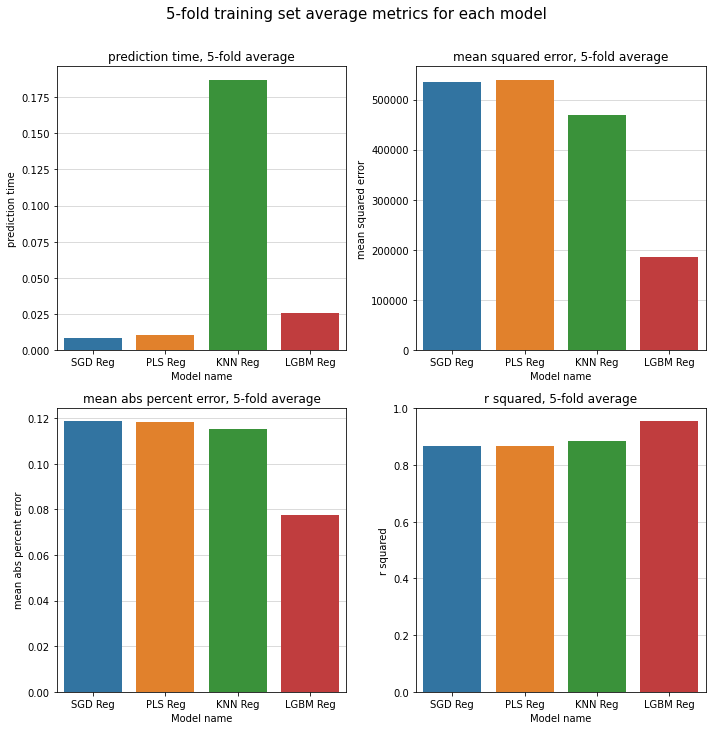

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for ax, metric in zip(fig.axes, model_metrics.columns.drop(['model', 'name'])):
    
    sns.barplot(
        x=model_metrics['name'].values,
        y=model_metrics[metric],
        ax=ax
    )
    
    ax.set_xlabel("Model name")
    ax.grid(True, axis='y', color='lightgrey')
    ax.set_axisbelow(True)
    ax.set_title(f'{metric}, 5-fold average')

fig.set_tight_layout(True)
fig.suptitle('5-fold training set average metrics for each model', y=1.01, fontsize=15)

plt.show()

In [72]:
best_model = min(model_metrics_list, key = lambda x: x['mean squared error'])
best_model_name = best_model['name']
best_model_score = best_model['mean squared error']
best_model = best_model['model']

In [73]:
print(f"The best model, based on the mean squared error obtained across the 5 training folds, is the {best_model_name} model, with a mean test score of {best_model_score:,.0f}.")

The best model, based on the mean squared error obtained across the 5 training folds, is the LGBM Reg model, with a mean test score of 185,385.


Moreover, the LGBM Regression model also offers the best mean absolute error as a %, and the best R2 score, as well as a reasonable prediction time compared to the other algorithms we tested.

We propose using this model for predicting the diamonds' value.

We can now look at the model's performance on the test set.

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [75]:
y_pred = best_model.predict(X_test)

In [79]:
print(f"On the test set, the model shows the following metrics:\n\
        - MSE: {mean_squared_error(y_test, y_pred):,.0f}\n\
        - MAPE: {mean_absolute_percentage_error(y_test, y_pred):.1%}\n\
        - R2: {r2_score(y_test, y_pred):.3f}")

On the test set, the model shows the following metrics:
        - MSE: 185,662
        - MAPE: 7.7%
        - R2: 0.955


These metrics are broadly in line with the results on the training set, showing moreover a decent MAPE and R2 score overall. We can continue using this model for predictive purposes.

In [80]:
import joblib

In [81]:
joblib.dump(best_model, 'model.joblib')

['model.joblib']